In [1]:
# -*- coding: utf-8 -*-
import h5py
import numpy as np
import os

from sklearn.model_selection import train_test_split
from lesion_extraction_2d.lesion_extractor_2d import get_train_data

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

In [2]:
h5_file_location = os.path.join('./','prostatex-train-ALL.hdf5')
h5_file = h5py.File(h5_file_location, 'r')

In [3]:
h5_file['ProstateX-0000']['Ktrans']['pixel_array']

<HDF5 dataset "pixel_array": shape (16, 128, 128), type "<f8">

In [13]:
# query = ['BVAL', 'ADC', 't2_tse_tra', 't2_tse_cor', 't2_tse_sag', 'Ktrans']
query = ['BVAL', 'ADC', 'Ktrans']
data = {q: get_train_data(h5_file, [q], size_px=32) for q in query}



Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDISTCALC_BVAL', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDIST_ADC', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0025/Ktrans', 'patient_id': '0025', 'ijk': b'67 88 -7', 'VoxelSpacing': b'1.5,1.5,3.', 'Zon

In [14]:
findings = {attr['patient_id'] + '-' + attr['fid']:{} for q in query for attr in data[q][2]}
for q in query:
    images, labels, attrs = data[q]
    for i in range(len(images)):
        f = attrs[i]['patient_id'] + '-' + attrs[i]['fid']
        image = images[i].astype(np.float64)
        findings[f][q] = image / image.max()
        if 'label' not in findings[f]:
            findings[f]['label'] = labels[i]
        else:
            assert(findings[f]['label'] == labels[i])
findings = {k:v for k, v in findings.items() if len(v.keys()) == len(query) + 1}
print("Total findings for train/val: ", len(findings))

Total findings for train/val:  321


In [15]:
images = np.stack([np.stack([findings[f][q] for q in query]) for f in findings])
labels = np.stack([findings[f]['label'] for f in findings])

In [21]:
splitted = train_test_split(
    images, labels, test_size=0.25, random_state=0, stratify=labels)
# X_train, X_valid, y_train, y_valid = (torch.Tensor(array) for array in splitted)
X_train, X_valid, y_train, y_valid = splitted
len_oversampled = len(y_train) - int(y_train.sum()) * 2
print("Train, len_1, len_oversampled: ", 
    len(y_train), int(y_train.sum()), len_oversampled)

oversampled = np.random.choice(np.where(y_train == 1)[0], len_oversampled)
X_train = np.concatenate((X_train, X_train[oversampled]), 0)
y_train = np.concatenate((y_train, y_train[oversampled]), 0)

Train, len_1, len_oversampled:  240 56 128


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

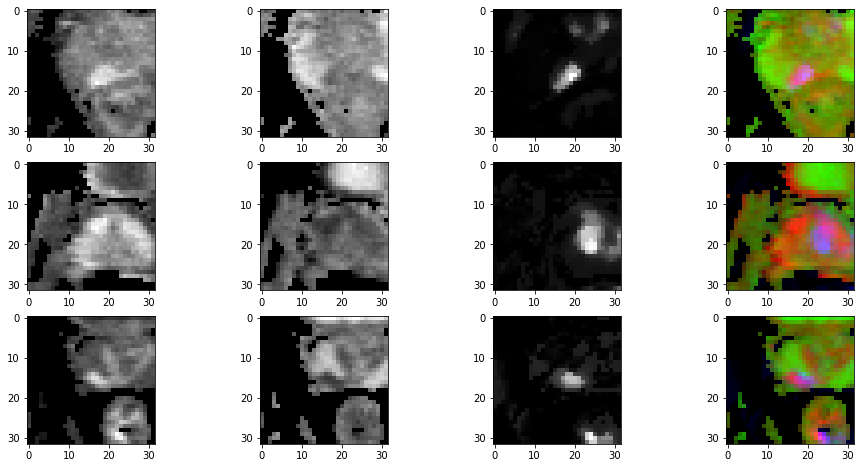

In [32]:
column = len(query) + 1 if len(query) < 5 else len(query)
row = [0, 1, 2]
fig, ax = plt.subplots(len(row), column, figsize=(4 * column, 8))
for r in row:
    if len(query) < 5: 
        for c in range(len(query)):
            ax[r, c].imshow(images[r, c], cmap='gray')
        ax[r, -1].imshow(np.moveaxis(images[r], 0, -1))
    else:
        for c in range(column):
            ax[r, c].imshow(images[r, c], cmap='gray')
fig.show()


In [34]:
from PIL import Image
images.shape

(321, 3, 32, 32)

In [39]:
images[i].shape

(3, 32, 32)

In [95]:
# for i in range(X_train.shape[0]):
#     image = X_train[i]
#     rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
#     im = Image.fromarray(np.moveaxis(rescaled, 0, -1))
#     im.save('dak_images/train/{}/{}.png'.format(1 if y_train[i] else 0, i))
for i in range(X_valid.shape[0]):
    if i < 28:
        image = X_valid[i]
        rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
        im = Image.fromarray(np.moveaxis(rescaled, 0, -1))
        im.save('dak_images/valid/{}/{}.png'.format(1 if y_valid[i] else 0, i))

In [61]:
transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(1/32, 1/32), shear=5),
    transforms.ToTensor()
])

datasets = {}
datasets['train'] = torchvision.datasets.ImageFolder('dak_images/train', transform=transform)
datasets['valid'] = torchvision.datasets.ImageFolder('dak_images/valid')

In [91]:
a = np.random.shuffle(datasets['valid'])

TypeError: 'ImageFolder' object does not support item assignment